# Looking at frequencies of officers being in the same country that their respective entities are in the jurisdiction of 

 This is a companion plot to the sankey diagram and is meant to further review  instances where officers live in the their entity's jurisdictions

In [1]:
## importing packages and libraries that we've used in class
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



## Functions used 

In [2]:
merged_df = pd.read_csv('ICIJ_Merged.csv')

/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_16369/1195876193.py:1: DtypeWarning: Columns (4,5,6,7,8,10,11,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,37,39,40,41,42,43,45,46,47,48,49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Normalize jurisdiction_description as before
def normalize_jurisdiction(name):
    if pd.isna(name):
        return ''
    name = name.lower()
    name = name.strip().replace('\n', '')
    if 'british anguilla' in name:
        name = name.replace('british anguilla', 'anguilla')
    name = name.replace('st.', 'saint')
    name = name.replace('st ', 'saint ')
    name = name.replace('&', 'and')
    name = ' '.join(name.split())
    name = name.replace('u.s.', 'us')
    if 'cookislands' in name:
        name = name.replace('cookislands', 'cook islands')
    if name == 'nevis':
        name = 'saint kitts and nevis'
    return name

In [4]:
merged_df.head()

,node_id_start,node_id_end,rel_type,link,status,start_date,end_date,sourceid,address_start,name_start,...,internal_id_end,incorporation_date_end,inactivation_date_end,struck_off_date_end,dorm_date_end,status_end,service_provider_end,ibcruc_end,type_end,closed_date_end
0,10002580,14106952,registered_address,registered address,NaN,NaN,NaN,Panama Papers,STEMBRIDGE TRUST (IRELAND) LIMITED 5 THE COURT...,FUSION TRADING LIMITED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10004460,14101133,registered_address,registered address,NaN,NaN,NaN,Panama Papers,MF CORPORATE (UK) LIMITED 520 S. 7TH STREET SU...,MF CORPORATE (UK) LIMITED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10023813,14105100,registered_address,registered address,NaN,NaN,NaN,Panama Papers,REIG INVESTMENTS LLP INVISION HOUSE WILBURY WA...,REIG INVESTMENTS LLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10023840,14100712,registered_address,registered address,NaN,NaN,NaN,Panama Papers,MARCUSSI INTERNATIONAL LLP INVISION HOUSE WILB...,MARCUSSI INTERNATIONAL LLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10010428,14093957,registered_address,registered address,NaN,NaN,NaN,Panama Papers,COLLYER BRISTOW LLP SOLICITORS 4 BEDFORD ROW L...,PULSAR HOLDINGS CORPORATION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plotting to show most popular entity jurisdictions for officers to base themselves in 

--- Officer Registration Analysis ---
Percentage of officers registered in the same jurisdiction as their entity: 32.43%


<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='jurisdiction_norm_end'>

Text(0.5, 1.0, 'Top 10 Jurisdictions: Officers in Same Jurisdiction as Entity')

Text(0.5, 0, 'Number of Unique Officers')

Text(0, 0.5, 'Entity Jurisdiction')

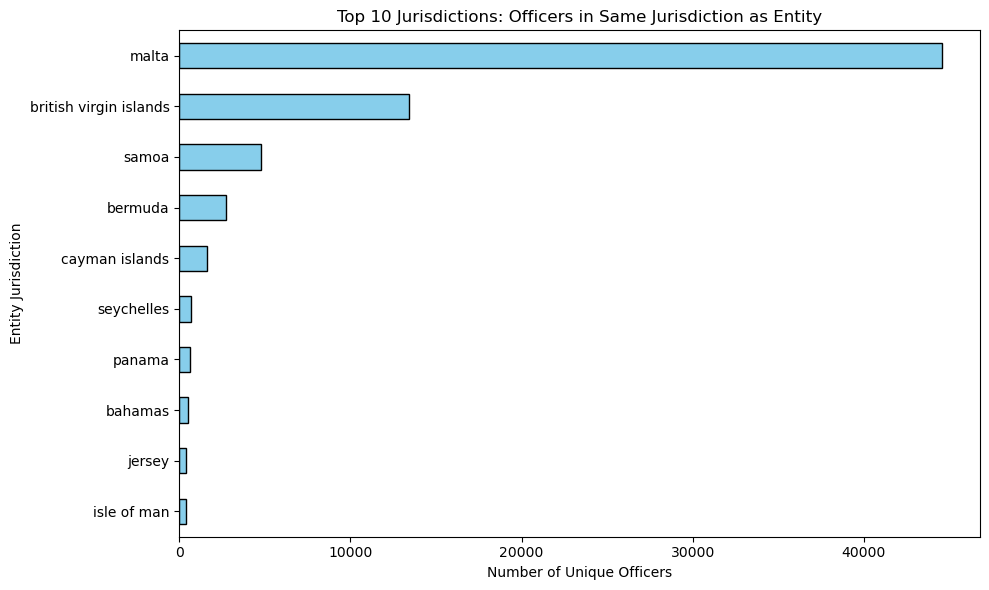

In [5]:
# Normalize jurisdiction for entities (node_end)
merged_df['jurisdiction_norm_end'] = merged_df['jurisdiction_description_end'].apply(normalize_jurisdiction) # Apply normalization to entity jurisdiction descriptions

# Normalize country for officers (node_start)
merged_df['countries_start_norm'] = merged_df['countries_start'].apply(normalize_jurisdiction) # Apply normalization to officer countries


print("--- Officer Registration Analysis ---") # Print header for the analysis
# Filter for links where an officer is connected to an entity and both country/jurisdiction are valid
officer_entity_links = merged_df[
    (merged_df['node_type_start'] == 'officer') & # Check if the starting node is an officer
    (merged_df['node_type_end'] == 'entity') & # Check if the ending node is an entity
    (merged_df['countries_start_norm'].notna()) & (merged_df['countries_start_norm'] != '') & # Ensure officer's normalized country is not null or empty
    (merged_df['jurisdiction_norm_end'].notna()) & (merged_df['jurisdiction_norm_end'] != '') # Ensure entity's normalized jurisdiction is not null or empty
].copy() # Create a copy to avoid SettingWithCopyWarning

    # Create a boolean column indicating if officer's country matches entity's jurisdiction
officer_entity_links['officer_in_entity_jurisdiction'] = \
        officer_entity_links['countries_start_norm'] == officer_entity_links['jurisdiction_norm_end']
    
    # Calculate the percentage of officers in the same jurisdiction as their entity
percentage_same_jurisdiction = (officer_entity_links['officer_in_entity_jurisdiction'].sum() * 100.0 / 
                                    len(officer_entity_links))
    # Print the calculated percentage
print(f"Percentage of officers registered in the same jurisdiction as their entity: {percentage_same_jurisdiction:.2f}%")

    # Count unique officers for each jurisdiction where officer and entity are in the same jurisdiction
same_jurisdiction_counts = officer_entity_links[officer_entity_links['officer_in_entity_jurisdiction']] \
        .groupby('jurisdiction_norm_end')['node_id_start'] \
        .nunique() \
        .sort_values(ascending=False) \
        .head(10) # Select the top 10 jurisdictions

plt.figure(figsize=(10, 6)) # Set the figure size for the plot

# Create a horizontal bar plot of the counts
same_jurisdiction_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 Jurisdictions: Officers in Same Jurisdiction as Entity') # Set the title of the plot
plt.xlabel('Number of Unique Officers') # Set the label for the x-axis
plt.ylabel('Entity Jurisdiction') # Set the label for the y-axis
plt.gca().invert_yaxis() # Invert y-axis to display the highest count at the top
plt.tight_layout() # Adjust plot layout to prevent labels from overlapping
plt.show() 
